In [1]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#define time range
t_start = 2.1
duration = 0.2
t_end = t_start + duration
shape = (180, 240)
dataset = "data/desk/"

In [3]:
events_raw = np.loadtxt(path + dataset + "events.txt", max_rows=1000000)

In [4]:
events_t = flt.filter_time(events_raw, t_start, t_end)

In [5]:
patch_center = (80, 70)
patch_size = 50
patch_center = (90, 90)
patch_size = 180
shape = (patch_size, patch_size)
events_p = flt.filter_patch(events_t, patch_center, patch_size)

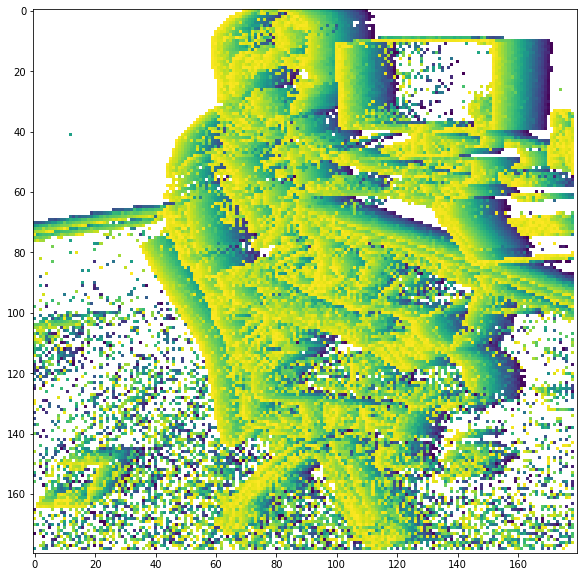

In [6]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_p, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

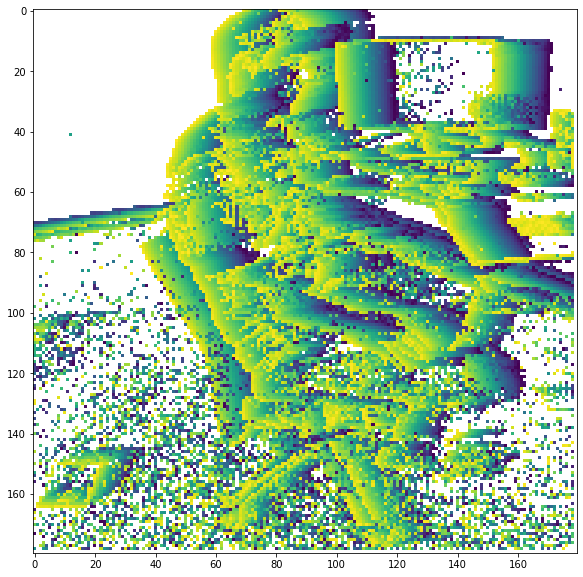

In [97]:
events = flt.filter_refract(events_p, 0.5)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False, polarity=0)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [98]:
events_raw[-1,0]

2.435887999

In [99]:
calib = np.loadtxt(path + dataset + "calib.txt")

In [109]:
poses = np.loadtxt(path + dataset + "groundtruth.txt")

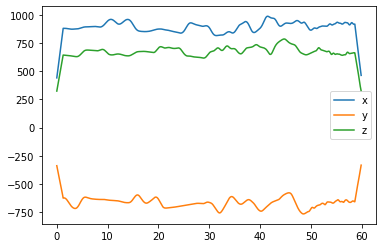

In [110]:
k = np.ones(500)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [111]:
time_d = td2d.TimeDifference2d(shape, events, poses, calib[0])

(2, 11958)


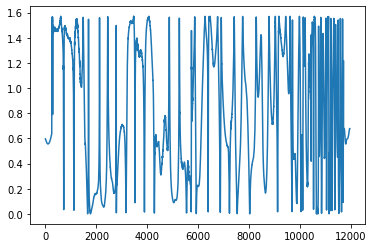

In [112]:
plt.plot(time_d.directions[:,1])

In [113]:
final_td, td_predictions, U, V, diff_list = time_d.compute_time_difference(dist = 2, px_range_pred=9, delay=0.15, avg_n=2, std_mul=1.01, debug=True, start_delay=0.05)

[ 0.01974963 -0.02193232 -0.10318746]


100%|█████████████████████████████████████████████████████████████████████████| 48587/48587 [00:03<00:00, 14528.78it/s]

total: 48587
diff: 181
negative: 1376
q: 0
ang: 0
ind: 8446
img: 3664
filtered: 0


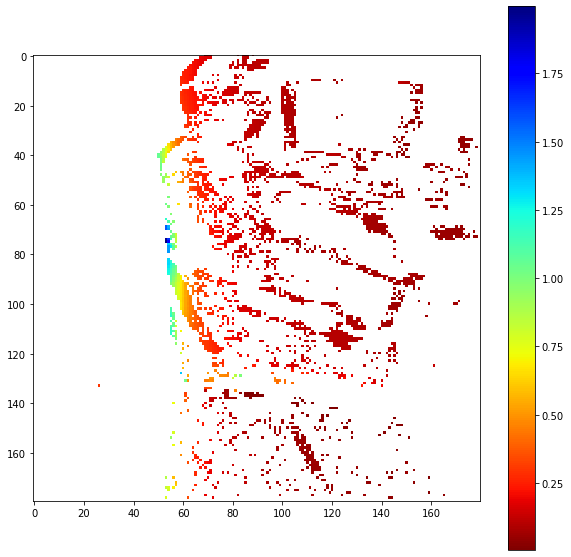

In [114]:
%matplotlib inline
plt.figure(figsize=(10, 10))
final_td_m = np.ma.masked_where(final_td == 0, final_td)
m = plt.imshow(final_td_m, cmap="jet_r", interpolation="none")
plt.colorbar(m)

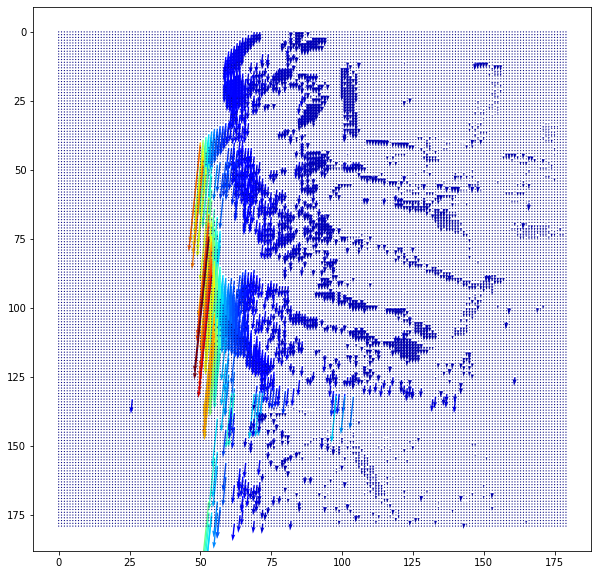

In [115]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, U, scale =10, cmap="jet_r")
plt.gca().invert_yaxis()

[ 0.01962944 -0.02197496 -0.10166359]


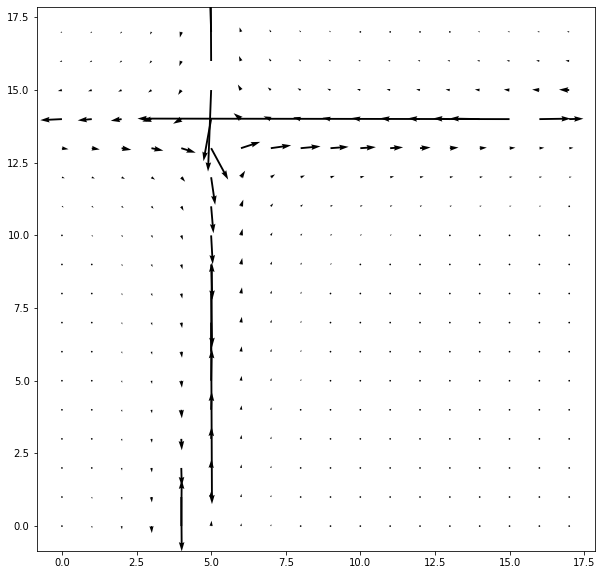

In [120]:
ang_flow_u, ang_flow_v = time_d.get_angular_flow(t_start)
plt.figure(figsize=(10, 10))
plt.quiver(ang_flow_u[::10, ::10], ang_flow_v[::10, ::10], scale =100, cmap="jet_r")

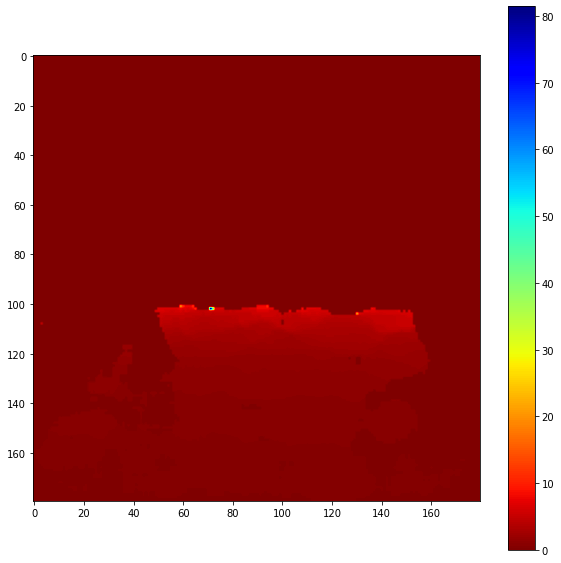

In [18]:
%matplotlib inline
img, count = td.median_from_dict(td_predictions, shape, 10)

plt.figure(figsize=(10, 10))
m = plt.imshow(img, cmap="jet_r")
plt.colorbar(m)

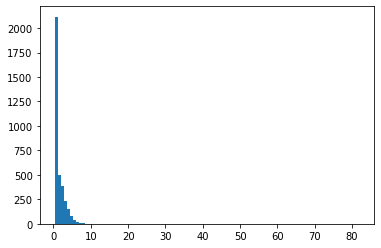

In [19]:
plt.hist(diff_list, 100);

In [20]:
u = np.divide(1.0, final_td_m, where=final_td!=0.0)
v = 0.158864
f = 335.419462958
d = td.v2depth(u, v, f)

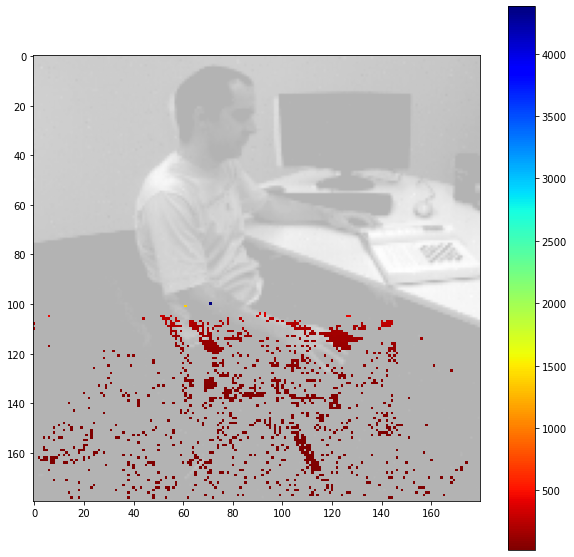

In [21]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img_gray = plt.imread(path + dataset + "/images/frame_00000027.png")
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(d, cmap="jet_r", interpolation="none")
plt.colorbar(m)

In [22]:
# %matplotlib qt
# vis.visualize3d(d)

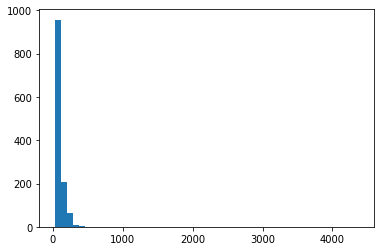

In [23]:
plt.hist(d.compressed(), 50);

In [24]:
np.mean(d.compressed())

80.63601549395787

In [25]:
np.var(d.compressed())

20325.762254218447

In [26]:
gt_d = 0.231

In [27]:
mean_error = np.mean(np.abs(d.compressed() - gt_d))
print(mean_error)

80.40501549395785


In [28]:
median_error = np.median(np.abs(d.compressed() - gt_d))
print(median_error)

50.44983401899309


In [29]:
p = mean_error / (d.compressed().max() - d.compressed().min())

In [30]:
p * 100

1.8457719109349273

In [31]:
print("mean error: {}\nmedian error: {}\nrelative error: {}".format(mean_error, median_error, p*100))

mean error: 80.40501549395785
median error: 50.44983401899309
relative error: 1.8457719109349273
